# INDIAN MEDICINAL LEAVES CLASSIFICATION USING TRANSFER LEARNING (INCEPTION V3)

Mounting drive in colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense , Flatten , Input , Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
#path of the dataset
dir_train = '/content/drive/My Drive/Medicinal_train'
dir_val = '/content/drive/My Drive/medicinal_val'

I am using batch size of 64 in order to reduce the computational requirments

In [ ]:
img_width, img_height = 299,299
batch_size = 64

DATA PIPELINE

In [ ]:
traintest_datagen = ImageDataGenerator(rescale=1. / 255)
validation_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
#data pipeline
train_data = traintest_datagen.flow_from_directory(
    dir_train,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_data = validation_datagen.flow_from_directory(
    dir_val,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

DATA DISTRIBUTION ACCROSS AMONG THE CLASSES

In [ ]:
class_indices = train_data.class_indices

# Create a dictionary to store the count of images for each class
class_counts = {class_name: 0 for class_name in class_indices.keys()}

# Iterate through the subdirectories and count the images for each class
for class_name, class_index in class_indices.items():
    class_dir = os.path.join(dir_train, class_name)
    class_count = len(os.listdir(class_dir))
    class_counts[class_name] = class_count

# Print the counts for each class
#for class_name, count in class_counts.items():
#    print(class_name , count)

In [ ]:
class_names = list(class_counts.keys())
counts = list(class_counts.values())

# Create a bar plot
sns.barplot(x=class_names, y=counts)
plt.xlabel('Class Index')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()

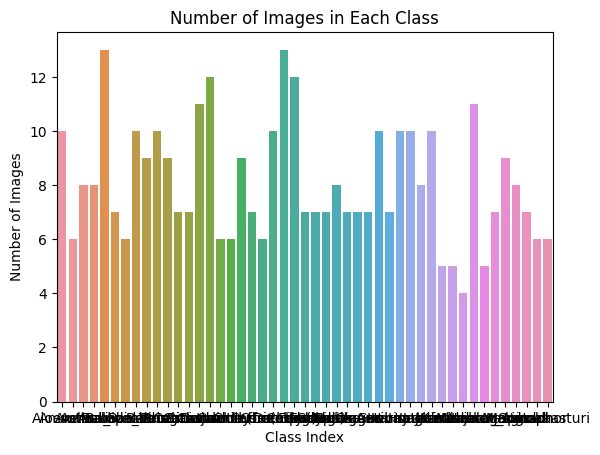

In [ ]:
lass_indices = validation_data.class_indices

# Create a dictionary to store the count of images for each class
class_counts = {class_name: 0 for class_name in class_indices.keys()}

# Iterate through the subdirectories and count the images for each class
for class_name, class_index in class_indices.items():
    class_dir = os.path.join(dir_val, class_name)
    class_count = len(os.listdir(class_dir))
    class_counts[class_name] = class_count

class_names = list(class_counts.keys())
counts = list(class_counts.values())

# Create a bar plot
sns.barplot(x=class_names, y=counts)
plt.xlabel('Class Index')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()


LOADING THE INCEPTION V3 MODEL WITH WEIGHTS TRAINED ON IMAGENET DATASET

In [ ]:
base_model = InceptionV3(weights= 'imagenet',
                         include_top=False,#removing the top layer
                         input_shape=(img_width, img_height, 3) ,
                         pooling = 'max')

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

Our top layer which gets the input from the output os the inception model

In [ ]:
x = Flatten()(base_model.output)
x = Dense(1024 , activation = 'relu' , kernel_regularizer = l2(0.01))(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(47 , activation = 'softmax')(x) #for 47 classes
model = Model(base_model.input , x)

In [ ]:
print('total no of layers in base model : ' ,len(base_model.layers))

total no of layers in base model :  312


In [ ]:
#we are going to train the parameters in the layera from 250 to increase the complexity of the model
for layer in base_model.layers[250:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

I trained the model with more than 32 epoches here it only shows 4 epoches (during early stages of training I uses low steps_per_epoch and increases it gradually)

In [ ]:
history = model.fit(
    train_data,
    validation_data = validation_data,
    epochs = 2,
    steps_per_epoch= 3)


Epoch 1/2
3/3 [==============================] - 109s 37s/step - loss: 18.1353 - accuracy: 0.0312 - val_loss: 19.4978 - val_accuracy: 0.0184
Epoch 2/2
3/3 [==============================] - 99s 35s/step - loss: 17.8204 - accuracy: 0.0417 - val_loss: 18.9551 - val_accuracy: 0.0184


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

In [ ]:
acc += history.history['accuracy']
loss += history.history['loss']
val_acc += history.history['val_accuracy']
val_loss += history.history['val_loss']

We get the test accuracy of 88+-2 %

In [ ]:
# Plot training & validation accuracy values
plt.subplot()
plt.plot(acc)
plt.plot(val_acc)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.subplot()
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.show()

Predicting individual images

In [ ]:
class_indices = train_data.class_indices
class_names = {v: k for k, v in class_indices.items()}

In [ ]:
batch = next(validation_data)
images , labels = batch

In [ ]:
image = np.expand_dims(images[1] , axis = 0)
predicted = model.predict(image)

In [ ]:
true_label = np.argmax(labels[1])
predicted_label = np.argmax(predicted)
print('true label : ' , class_names[true_label])
print('predicted label : ' ,class_names[predicted_label])
plt.imshow(images[1])

Saving the model and reload the model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
saved_model = load_model('/content/drive/My Drive/saved_model/model1.h5')

In [ ]:
saved_model.evaluate(train_data , steps = 8)

8/8 [==============================] - 155s 22s/step - loss: 7.6387 - accuracy: 1.0000


[7.638710975646973, 1.0]

In [ ]:
saved_model.evaluate(validation_data)

6/6 [==============================] - 8s 1s/step - loss: 8.1268 - accuracy: 0.8816


[8.126832008361816, 0.8815789222717285]

In [ ]:
image = np.expand_dims(images[3] , axis = 0)
predicted = saved_model.predict(image)

1/1 [==============================] - 0s 87ms/step


true label :  Bringaraja
predicted label :  Bringaraja


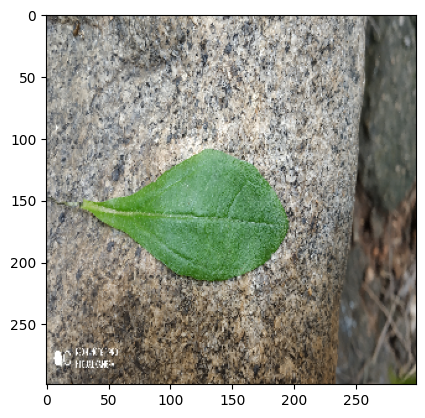

In [ ]:
true_label = np.argmax(labels[3])
predicted_label = np.argmax(predicted)
print('true label : ' , class_names[true_label])
print('predicted label : ' ,class_names[predicted_label])
plt.imshow(images[3])

In [ ]:
batch = next(validation_data)
images , labels = batch

In [ ]:
# Initialize empty lists to store images and labels
all_images = []
all_labels = []

# Iterate through the entire dataset
for batch in validation_data:
    images, labels = batch
    all_images.append(images)
    all_labels.append(labels)

    # Check if we have iterated through the entire dataset
    if len(all_images) * batch_size >= len(validation_data.filenames):
        break

# Concatenate the lists to obtain the entire dataset
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Verify the shapes
print("All Images Shape:", all_images.shape)
print("All Labels Shape:", all_labels.shape)

All Images Shape: (380, 299, 299, 3)
All Labels Shape: (380, 47)


In [ ]:
image = np.expand_dims(all_images , axis = 0)
predicted = saved_model.predict(all_images)

12/12 [==============================] - 1s 124ms/step


PLOTTING THE CONFUSION MATRIX IN VALIDATION DATA

In [ ]:
predicted_label = np.argmax(predicted , axis = 1)
true_label = np.argmax(all_labels , axis = 1)
con = confusion_matrix(true_label , predicted_label)

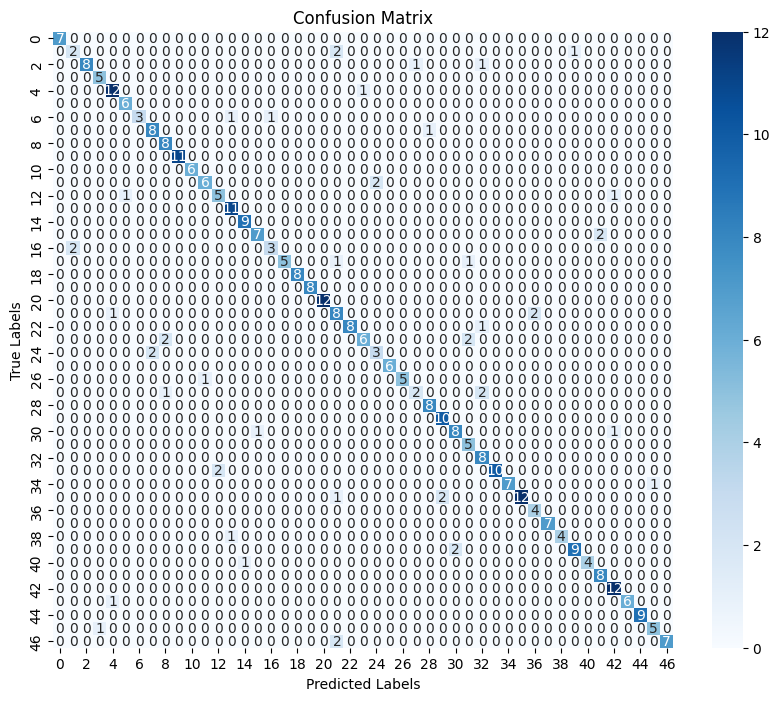

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(con, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

CLASSIFICATION REPORT

In [ ]:
print(classification_report(true_label, predicted_label))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.50      0.40      0.44         5
           2       1.00      0.80      0.89        10
           3       0.83      1.00      0.91         5
           4       0.86      0.92      0.89        13
           5       0.86      1.00      0.92         6
           6       1.00      0.60      0.75         5
           7       0.80      0.89      0.84         9
           8       0.73      1.00      0.84         8
           9       1.00      1.00      1.00        11
          10       1.00      1.00      1.00         6
          11       0.86      0.75      0.80         8
          12       0.71      0.71      0.71         7
          13       0.85      1.00      0.92        11
          14       0.90      1.00      0.95         9
          15       0.88      0.78      0.82         9
          16       0.75      0.60      0.67         5
          17       1.00    

PLOTTING THE ROC AND PR CURVE

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc , roc_curve

In [ ]:
y_true_bin = label_binarize(true_label, classes=np.unique(true_label))
y_scores = label_binarize(predicted_label, classes=np.unique(predicted_label))

In [ ]:
print(y_true_bin.shape)
print(y_scores.shape)

(380, 47)
(380, 47)


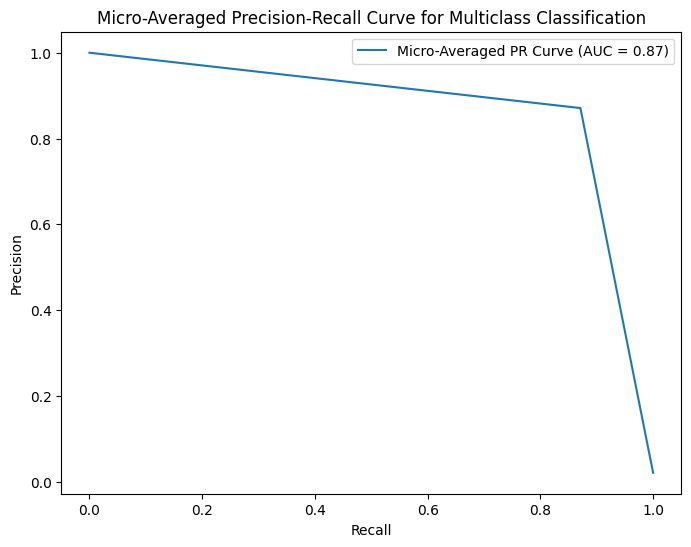

In [ ]:
precision, recall, _ = precision_recall_curve(y_true_bin.ravel(), y_scores.ravel())
micro_auc = auc(recall, precision)

# Plot the micro-averaged PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Micro-Averaged PR Curve (AUC = {micro_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-Averaged Precision-Recall Curve for Multiclass Classification')
plt.legend()
plt.show()

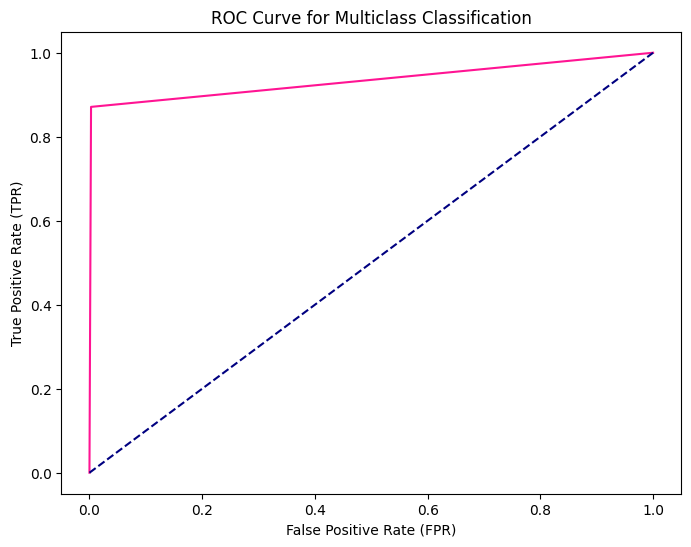

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_true_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-Averaged ROC Curve (AUC = {roc_auc["micro"]:.2f})', color='deeppink')



plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Multiclass Classification')
plt.show()